# Sech

In [38]:
import math as m
import cmath as cm
import sympy as sp

import DistExampB as db

from math import sqrt
from matplotlib import pyplot as plot
from scipy.linalg import lstsq
from scipy.optimize import fsolve

from Map import LogRatio
from LocUtil import Grid1, UnZip

## Set Up

#### constants

In [39]:
nPlot = 501

#### problem

In [40]:
dist = db.ExampB()

#### maping

In [41]:
xSym = sp.Symbol('x')
zSym = sp.Symbol('z')
map_ = LogRatio(xSym, zSym, xRange=(0, 2))
map_.forSym

log(x/(2 - x))

In [42]:
X2Z = map_.Forward
Z2X = map_.Inverse

#### bases

In [43]:
hSym = sp.Symbol('h', positive=True)
zkSym = sp.Symbol('zk', real=True)

In [44]:
baseZ = 1/sp.pi * 1 / sp.cosh((zSym - zkSym) / hSym)
baseZ

1/(pi*cosh((z - zk)/h))

In [45]:
sp.integrate(baseZ, (zSym,-sp.oo,sp.oo))

Integral(1/cosh(z/h - zk/h), (z, -oo, oo))/pi

In [46]:
BaseZ = sp.lambdify((zSym,zkSym,hSym), baseZ)

Text(0.5, 0, 'h')

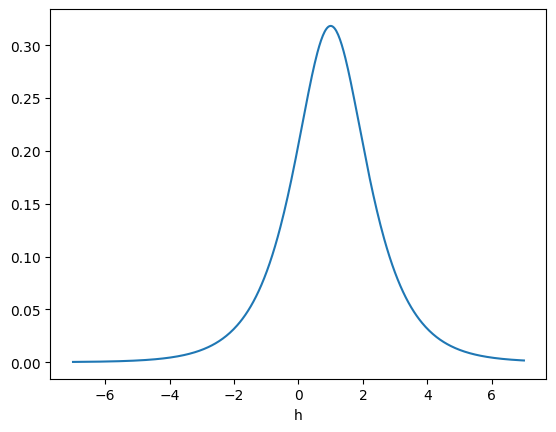

In [47]:
zGrid = Grid1(-7,7, nPlot)
baseGrid = tuple(BaseZ(z,1,1) for z in zGrid)

plot.plot(zGrid,baseGrid)

plot.xlabel('h')

## Fit to PDF

In [48]:
PdfZ = lambda z: dist.Pdf(map_.Inverse(z))

In [49]:
zMin = fsolve(lambda z: PdfZ(z) - 0.01, -3)[0]
zMax = fsolve(lambda z: PdfZ(z) - 0.01, 6)[0]
zMin,zMax

(-3.1026021373001056, 6.393525850353921)

(0.001, 2)

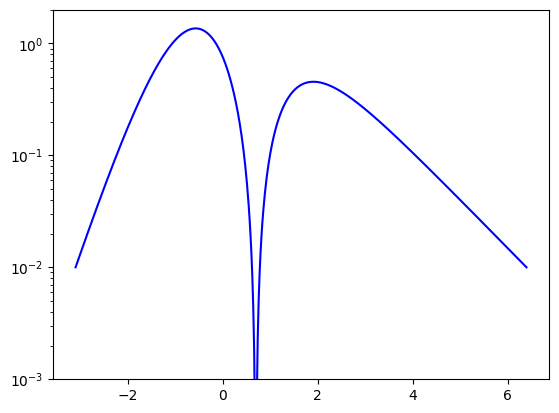

In [50]:
fig,ax = plot.subplots()

zGrid = Grid1(zMin,zMax, nPlot)
pdf = tuple(PdfZ(z) for z in zGrid)

plot.semilogy(zGrid,pdf, c='blue')

ax.set_ylim(1e-3,2)

In [51]:
def Fit(zRange, nBase):
	assert(1 < nBase)
	zMin,zMax = zRange
	
	sechZ = Grid1(*zRange, nBase)
	h = (zMax - zMin) / (nBase - 1)
	
	mat = []
	for matchZ in sechZ:
		mat.append([BaseZ(matchZ,baseZ,h) for baseZ in sechZ])
	rhs = [PdfZ(z) for z in sechZ]
	
	fit = lstsq(mat, rhs)
	weight,res,rank,singVal = fit

	condNum = singVal[0] / singVal[nBase - 1]
	
	return ((sechZ,weight),  condNum)

In [55]:
sechApprox,condNum = Fit((zMin,zMax), nSech)
condNum

34.447909297746556

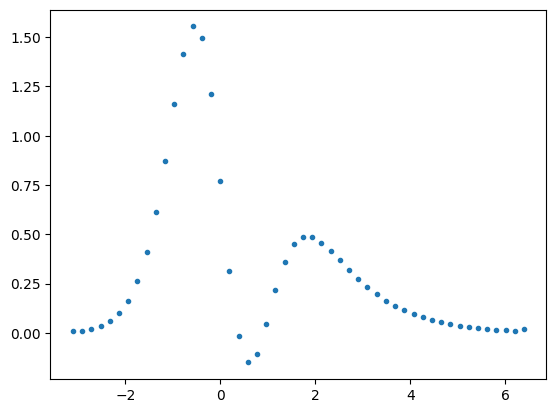

In [56]:
plot.plot(*sechApprox, '.')

In [57]:
extZRange = tuple(z*s for (z,s) in zip((zMin,zMax), (2,2)))
extZRange

(-6.205204274600211, 12.787051700707842)

In [58]:
def Interp0(sechZ,sechV,h, z):
	result = sum(sv * BaseZ(z,sz,h) for (sz,sv) in zip(sechZ, sechV))

	return result

In [59]:
def Interp1(sechApprox, zGrid):
	sechZ,sechV = sechApprox
	
	nSech = len(sechZ)
	zMin,zMax = (sechZ[0], sechZ[nSech - 1])
	h = (zMax - zMin) / (nSech - 1)
	
	result = tuple(Interp0(sechZ,sechV,h, z) for z in zGrid)
	return result

(0.0001, 2)

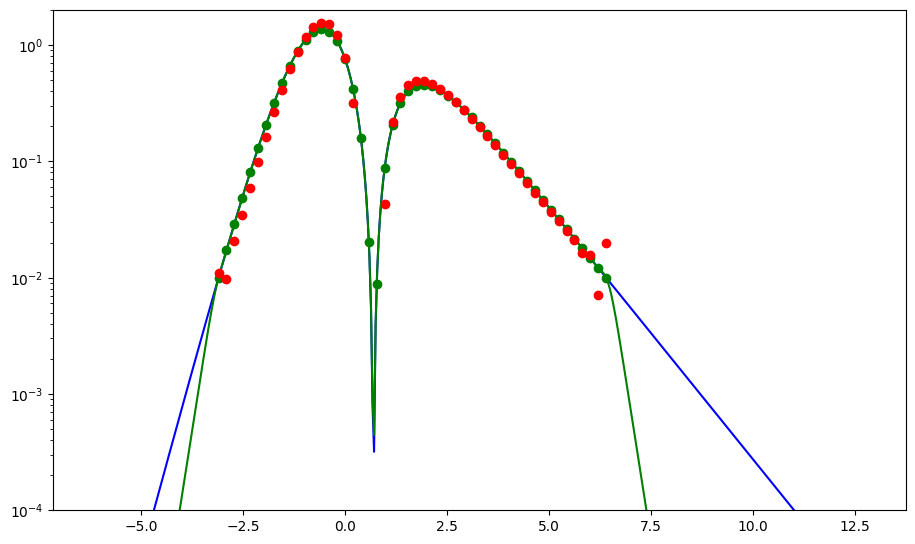

In [61]:
fig,ax = plot.subplots(figsize=(11, 6.5))

zGrid = Grid1(*extZRange, 501)
pdf = tuple(PdfZ(z) for z in zGrid)
plot.semilogy(zGrid,pdf, c='blue')

est = Interp1(sechApprox, zGrid)
plot.semilogy(zGrid,est, c='green')

sechZ,weight = sechApprox
sechV = tuple(PdfZ(z) for z in sechZ)
plot.semilogy(sechZ,sechV, 'o', c='green')

for (zBase,w) in zip(sechZ,weight):
	plot.semilogy(zBase,w, 'o', c='red')
	
ax.set_ylim(1e-4,2)

In [251]:
# zGrid = Grid1(*extZRange, nPlot)
# diff = tuple(Interp0(weight,))



In [68]:
def ErrorZ(sechApprox, F):
	sechZ,weight = sechApprox
	
	nSech = len(sechZ)
	zMin,zMax = sechZ[0],sechZ[nSech - 1]
	h = (zMax - zMin) / (nSech - 1)
		
	Diff = lambda z: Interp0(sechZ,weight,h, z) - F(z)
	
	extZRange = tuple(z * s for (z,s) in zip((zMin,zMax), (2,2)))
	nSinc = 4 * nSech
	
	sincZ = Grid1(*extZRange, nSinc)
	diff = tuple(Diff(z) for z in sincZ)
	
	result = sqrt(h * sum(d*d for d in diff))
	return result

In [69]:
PdfZ = lambda z: dist.Pdf(map_.Inverse(z))

In [70]:
ErrorZ(sechApprox, PdfZ)

0.0069013039609905884

In [74]:
def ErrN(F, nSech, zRange):
	sechEst,condNum = Fit(zRange,nSech)

	errEst = ErrorZ(sechEst, F)
	
	return (errEst, condNum)

In [75]:
ErrN(PdfZ, 70, (zMin,zMax))

(0.007968158657456082, 34.60228664120426)

In [82]:
errN = tuple((n,ErrN(PdfZ,n,(zMin,zMax))) for n in range(3,70))

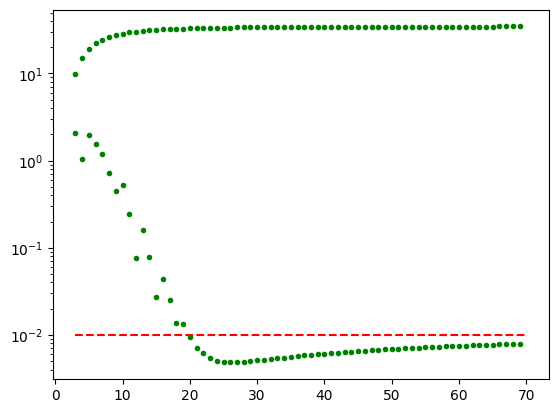

In [83]:
plot.semilogy(*UnZip(errN), '.', c='green')

plot.semilogy((3,70), (0.01,0.01), '--',c='red')